In [ ]:
import numpy as np
import pandas as pd
import run_yasa
import logging
import mne
import yasa
import os
import argparse
import os

import mne
import numpy as np
import pandas as pd
from brainflow.board_shim import BoardShim, BoardIds
from brainflow.data_filter import DataFilter

from memory import garbage_collect

log = lambda msg: logging.info(msg)


# Load data

In [ ]:
input_dir = "C:\\dev\\play\\brainwave-data"


In [ ]:
import sleep_events
from importlib import reload
reload(sleep_events)


nights = sleep_events.load_nights_data()

In [ ]:
nights

In [ ]:
import stitch_pipeline_results
from importlib import reload
reload(stitch_pipeline_results)

df_orig = stitch_pipeline_results.stitch_all_days_optimised(input_dir)
df = df_orig.copy()

In [ ]:
import stitch_pipeline_results
from importlib import reload
reload(stitch_pipeline_results)
from stitch_pipeline_results import post_stitch

df = df_orig.copy()
df = post_stitch(df)


In [ ]:
reload(stitch_pipeline_results)
from stitch_pipeline_results import find_long_wakes
# Plot hypnogram
import matplotlib.pyplot as plt

def draw_day(interesting_day):
    df_for_day = df[df['dayAndNightOf'] == interesting_day].reset_index()

    # Map stages to numeric values for plotting
    stage_map = {'W': 4, 'R': 3, 'N1': 2, 'N2': 1, 'N3': 0}
    stage_values = df_for_day['Stage'].map(stage_map)

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 5), sharex=True, gridspec_kw={'height_ratios': [2, 0.5, 0.5, 1]})

    # Plot stages
    ax1.plot(stage_values, linewidth=1)
    ax1.set_yticks(list(stage_map.values()))
    ax1.set_yticklabels(list(stage_map.keys()))
    ax1.set_ylabel('Sleep Stage')
    ax1.grid(True)

    # Plot long wakes
    ax2.fill_between(df_for_day.index, 0, df_for_day['SSWakeDuringSleep'].astype(int), color='red')
    ax2.set_ylabel('Wake')

    ax3.fill_between(df_for_day.index, 0, df_for_day['SSDuringLongWake'].astype(int), color='red')
    ax3.set_ylabel('Long\nWake')

    ax4.plot(df_for_day['SSMinsUntilLongWake'], color='red')
    ax4.set_ylabel('MinsTo\nLongWake')


    plt.tight_layout()
    plt.show()

interesting_day = "2024-12-28"
df_for_day = df[df['dayAndNightOf'] == interesting_day]
display(df_for_day['SSWakeDuringSleep'].value_counts())
long_wakes = find_long_wakes(df_for_day)
display(len(long_wakes))

draw_day(interesting_day)

In [ ]:
grouped = df.groupby('dayAndNightOf').agg(
    dayAndNightOf=('dayAndNightOf', 'first'),
    HasLongWake=('SSLongWakeThisNight', 'any'),
    SSDuringLongWake_True=('SSDuringLongWake', lambda x: (x == True).sum()),
    SSDuringLongWake_False=('SSDuringLongWake', lambda x: (x == False).sum()),
    SSLongWakeThisNight_True=('SSLongWakeThisNight', lambda x: (x == True).sum()),
    SSLongWakeThisNight_false=('SSLongWakeThisNight', lambda x: (x == False).sum()),
    MeanMinsUntilLongWake=('SSMinsUntilLongWake', 'mean')
)
grouped

In [157]:
import models.util.nights as n

actual_insomnia_nights = n.actual_insomnia_nights

In [153]:
has_long_wake = grouped[grouped['HasLongWake']]['dayAndNightOf'].dt.date
has_long_wake = {str(date) for date in has_long_wake}
has_long_wake

{'2024-08-24',
 '2024-09-08',
 '2024-09-15',
 '2024-10-11',
 '2024-10-15',
 '2024-11-02',
 '2024-12-05',
 '2024-12-28'}

In [154]:

actual_insomnia_nights_that_do_not_have_long_wake = set(actual_insomnia_nights) - set(has_long_wake)
long_wake_nights_that_should_not_be = set(has_long_wake) - set(actual_insomnia_nights)
display(actual_insomnia_nights_that_do_not_have_long_wake)
display(long_wake_nights_that_should_not_be)

{'2024-11-05'}

set()

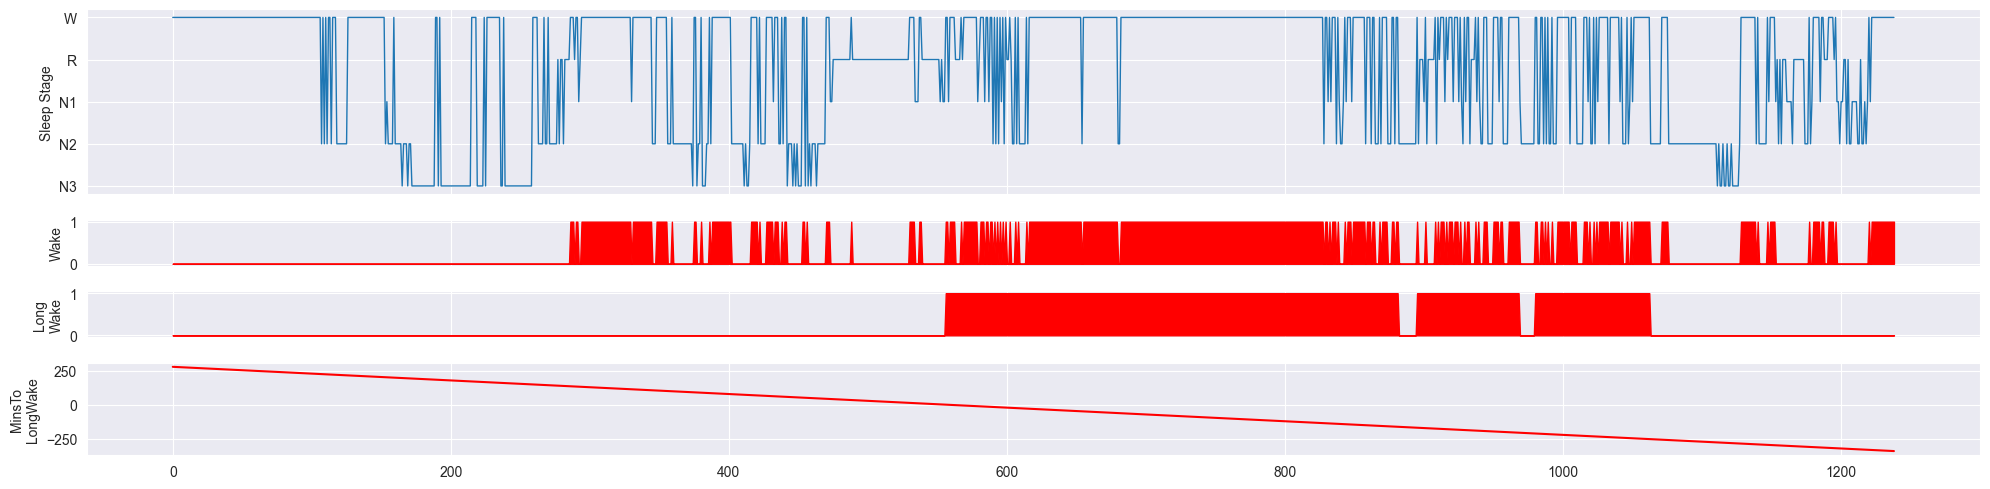

In [151]:
draw_day("2024-09-08")

In [ ]:
interesting_day = '2024-08-20'
df_for_day = df[df['dayAndNightOf'] == interesting_day].reset_index()
display(find_long_wakes(df_for_day))
draw_day(interesting_day)

In [ ]:
for night in has_long_wake:
    print(str(night.date()))
    draw_day(str(night.date()))


In [ ]:
from sleep_events import load_days_data

day_data = load_days_data()

In [ ]:
day_data_orig = day_data.copy()

In [ ]:
import sleep_events
reload(sleep_events)

day_data = sleep_events.pimp_my_days_data(day_data_orig)

In [106]:
[col for col in day_data.columns if 'wake' in col and 'night' in col]

['night:aggregated:wakeTimeSSM',
 'night:fitbit:adjusted:timeAwakeAfterSleepSecs',
 'night:aggregated:timeAwakeAfterSleepSecs',
 'night:fitbit:source:wakeTimeSSM',
 'night:fitbit:source:timeAwakeAfterSleepSecs',
 'night:fitbit:adjusted:wakeTimeSSM',
 'night:aggregated:wakePct',
 'night:yasa:source:wakeTimeSSM',
 'night:yasa:source:timeAwakeAfterSleepSecs',
 'night:yasa:adjusted:timeAwakeAfterSleepSecs',
 'night:yasa:adjusted:wakeTimeSSM']

In [107]:
day_data[['dayAndNightOf', 'timeAwakeAfterSleep', 'night:hasYasa', 'wakeTime']]

,dayAndNightOf,timeAwakeAfterSleep,night:hasYasa,wakeTime
0,2024-04-21,NaT,NaN,NaT
1,2024-04-22,NaT,NaN,NaT
2,2024-04-23,NaT,NaN,NaT
3,2024-04-24,NaT,NaN,NaT
4,2024-04-25,NaT,NaN,NaT
...,...,...,...,...
248,2024-12-25,0 days 00:46:30,False,2024-12-26 08:19:00+00:00
249,2024-12-26,0 days 02:47:30,False,2024-12-27 07:57:00+00:00
250,2024-12-27,0 days 00:50:36,True,2024-12-28 07:06:34+00:00
251,2024-12-28,0 days 04:29:29,True,2024-12-29 08:08:53+00:00


In [110]:
possibly_insomnia_nights = day_data[(day_data['night:hasYasa']) & (day_data['timeAwakeAfterSleep'] > pd.Timedelta(minutes=60))][['dayAndNightOf', 'timeAwakeAfterSleep', 'night:hasYasa', 'wakeTime']]
possibly_insomnia_nights

,dayAndNightOf,timeAwakeAfterSleep,night:hasYasa,wakeTime
92,2024-07-22,0 days 01:07:37,True,2024-07-23 07:32:00+01:00
97,2024-07-27,0 days 01:01:39,True,2024-07-28 08:41:00+01:00
120,2024-08-19,0 days 01:36:25,True,2024-08-20 06:46:00+01:00
121,2024-08-20,0 days 04:05:49,True,2024-08-21 07:04:00+01:00
125,2024-08-24,0 days 03:33:10,True,2024-08-25 08:34:00+01:00
126,2024-08-25,0 days 01:45:14,True,2024-08-26 08:07:30+01:00
133,2024-09-01,0 days 01:15:48,True,2024-09-02 07:14:46+01:00
134,2024-09-02,0 days 01:40:43,True,2024-09-03 06:51:00+01:00
135,2024-09-03,0 days 05:52:54,True,2024-09-04 07:39:00+01:00
140,2024-09-08,0 days 04:42:14,True,2024-09-09 08:12:10+01:00


In [111]:
actual_insomnia_nights_dates

{datetime.date(2024, 8, 19),
 datetime.date(2024, 8, 20),
 datetime.date(2024, 8, 24),
 datetime.date(2024, 9, 3),
 datetime.date(2024, 9, 15),
 datetime.date(2024, 10, 11),
 datetime.date(2024, 10, 15),
 datetime.date(2024, 11, 2),
 datetime.date(2024, 11, 5),
 datetime.date(2024, 12, 5),
 datetime.date(2024, 12, 28)}

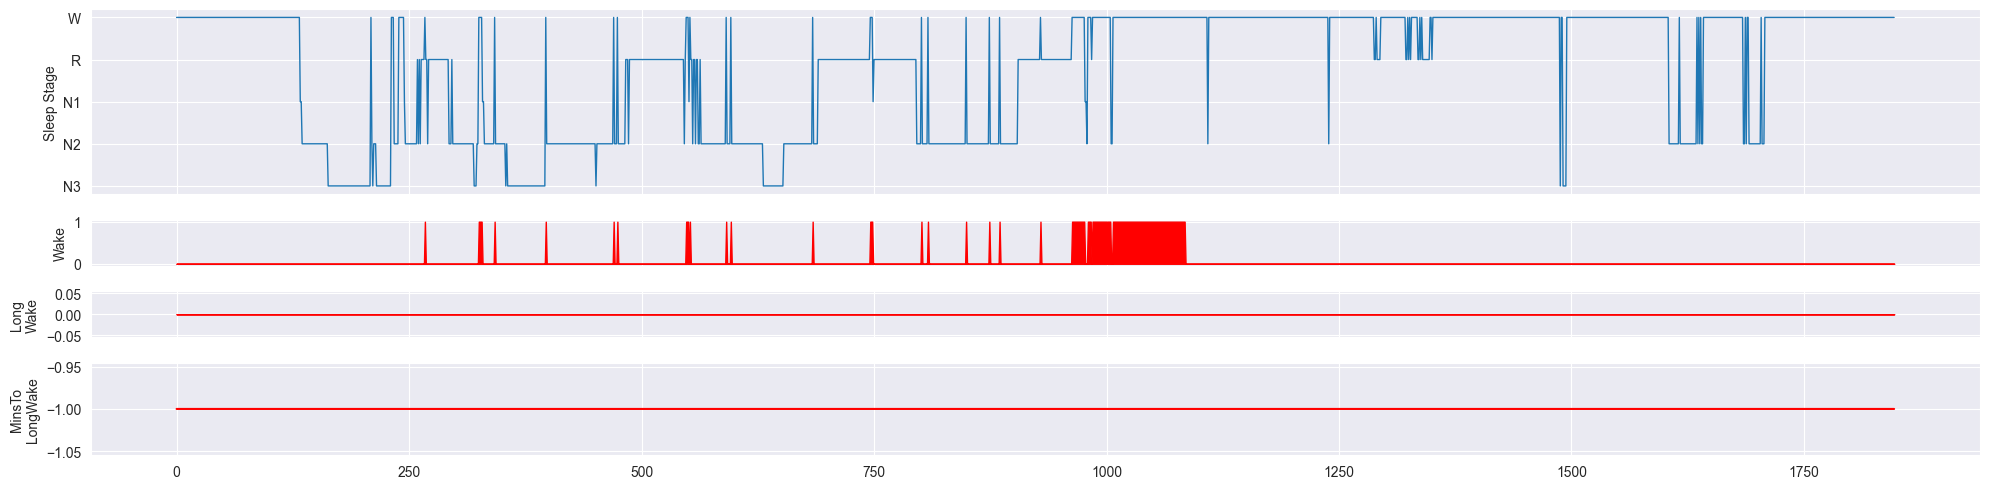

In [117]:
draw_day('2024-08-19')

In [128]:
str("2024-08-19") in actual_insomnia_nights

True

2024-07-22
2024-07-27
2024-08-19
06:46:00


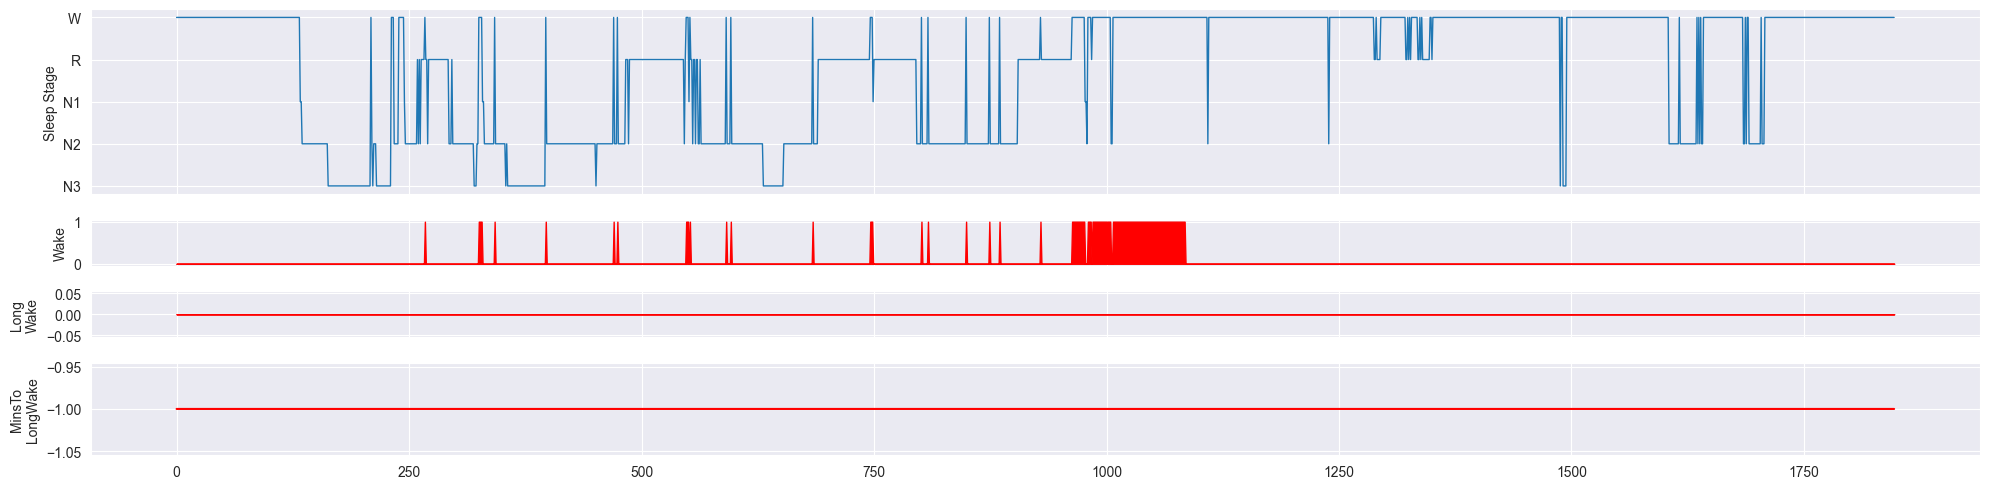

2024-08-20
07:04:00


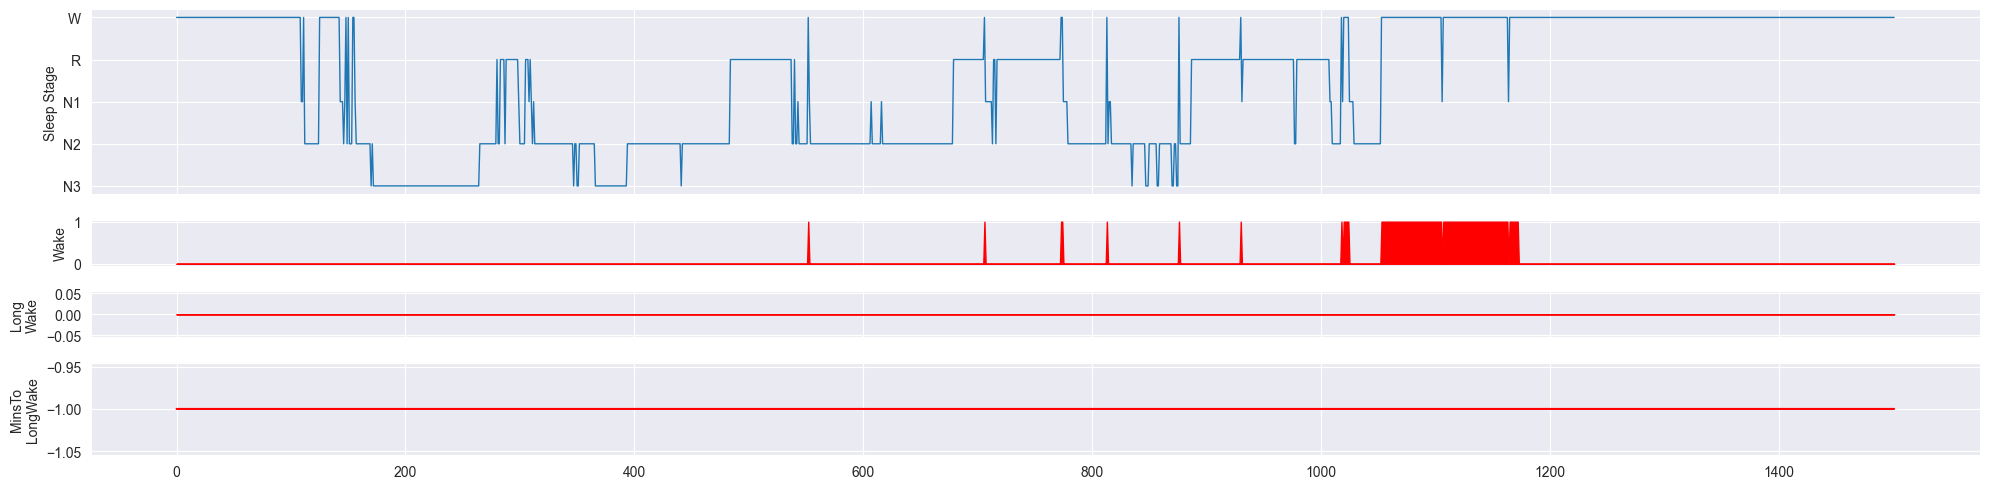

2024-08-24
08:34:00


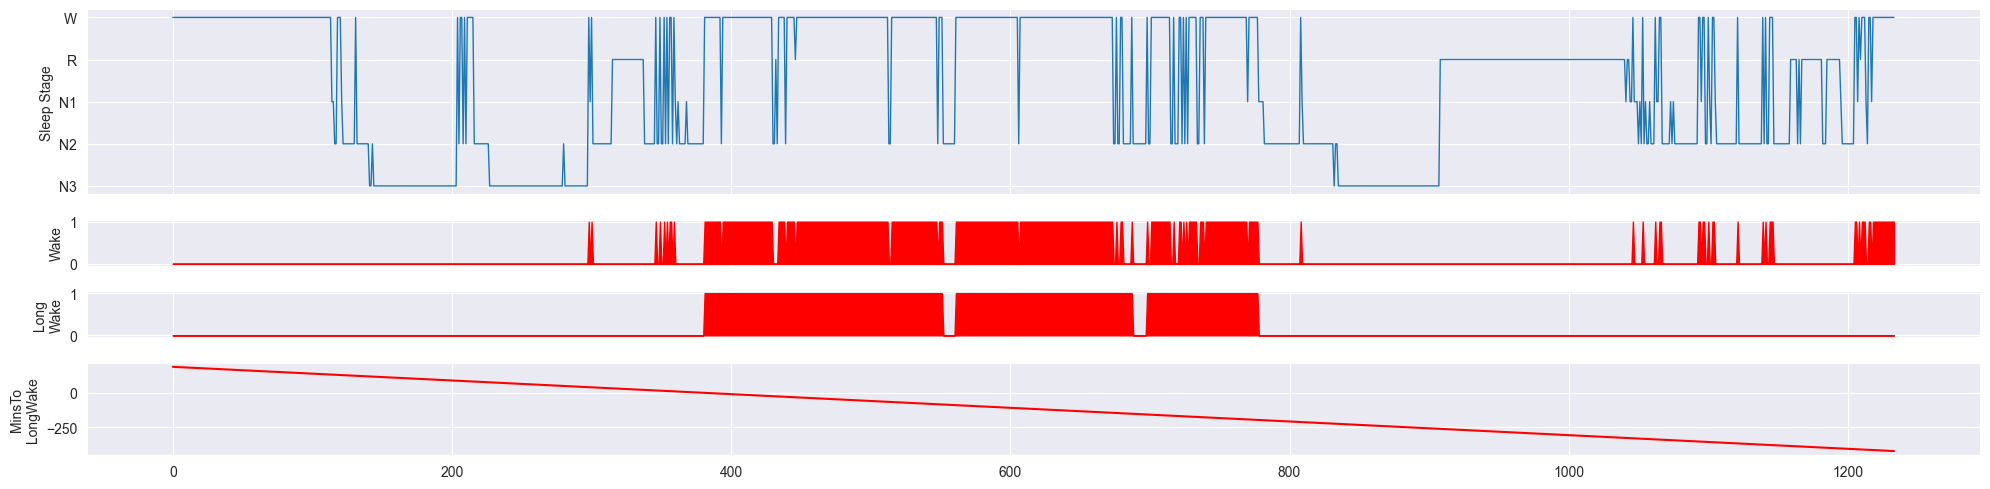

2024-08-25
2024-09-01
2024-09-02
2024-09-03
07:39:00


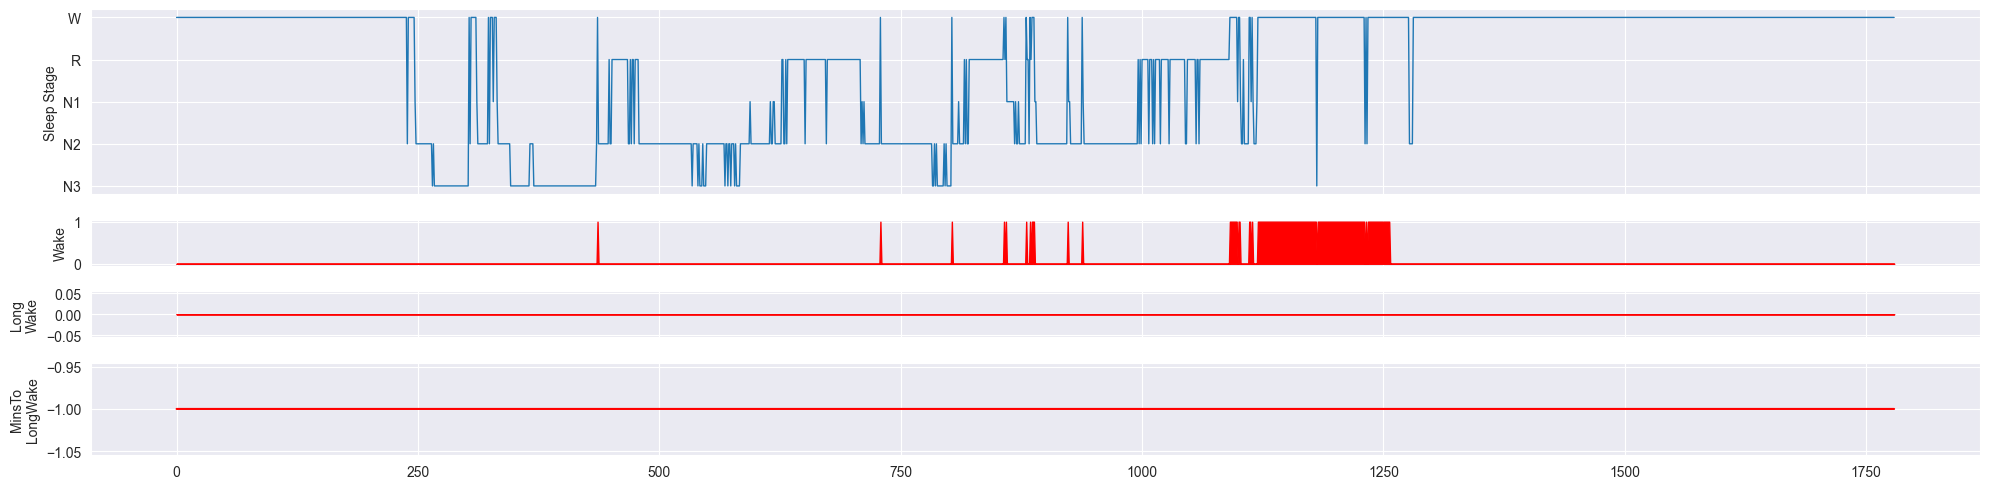

2024-09-08
2024-09-15
09:01:06


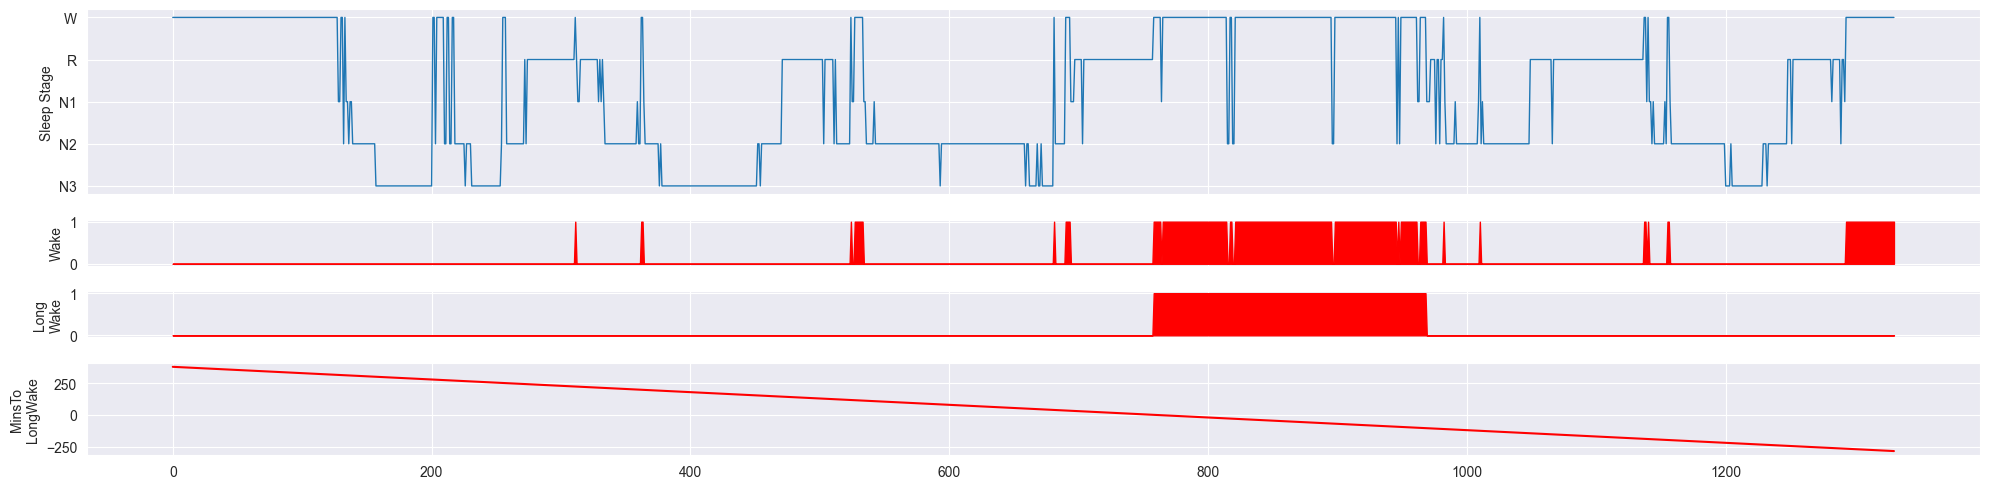

2024-09-25
2024-09-26
2024-10-01
2024-10-09
2024-10-11
10:03:00


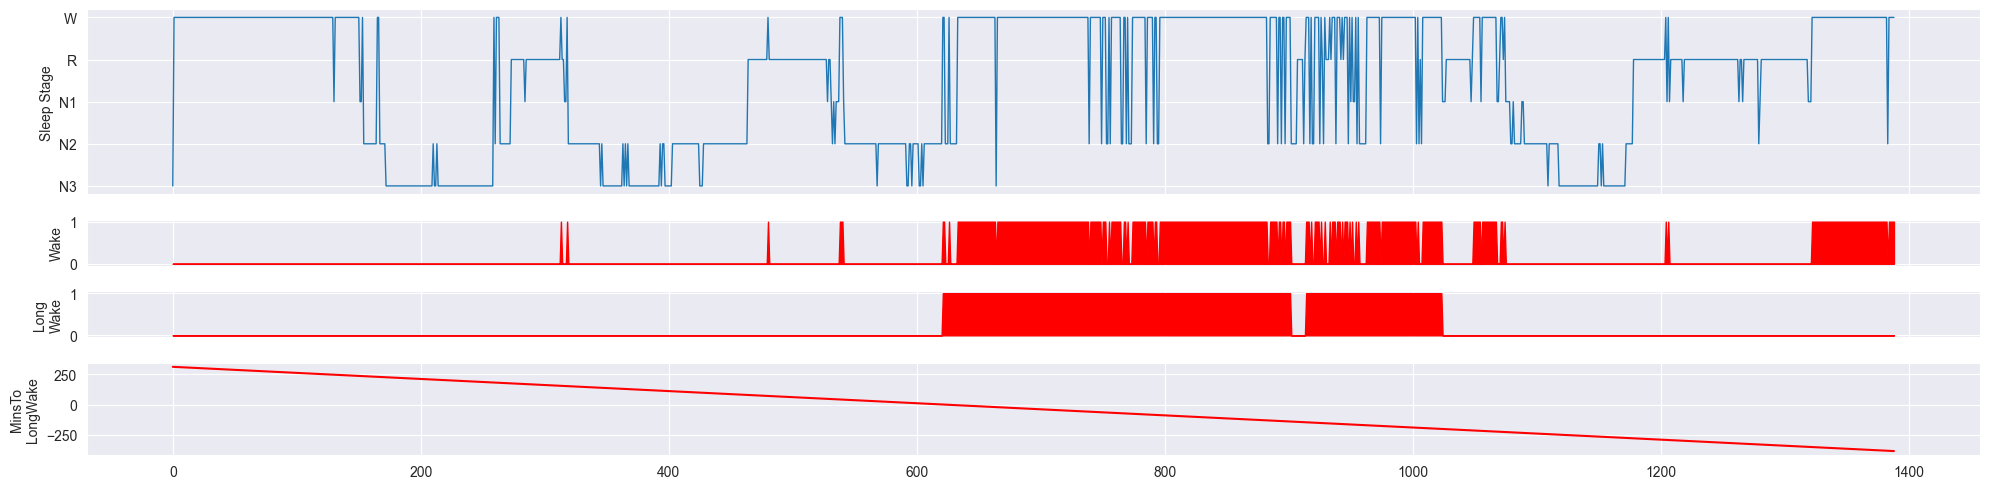

2024-10-15
08:45:00


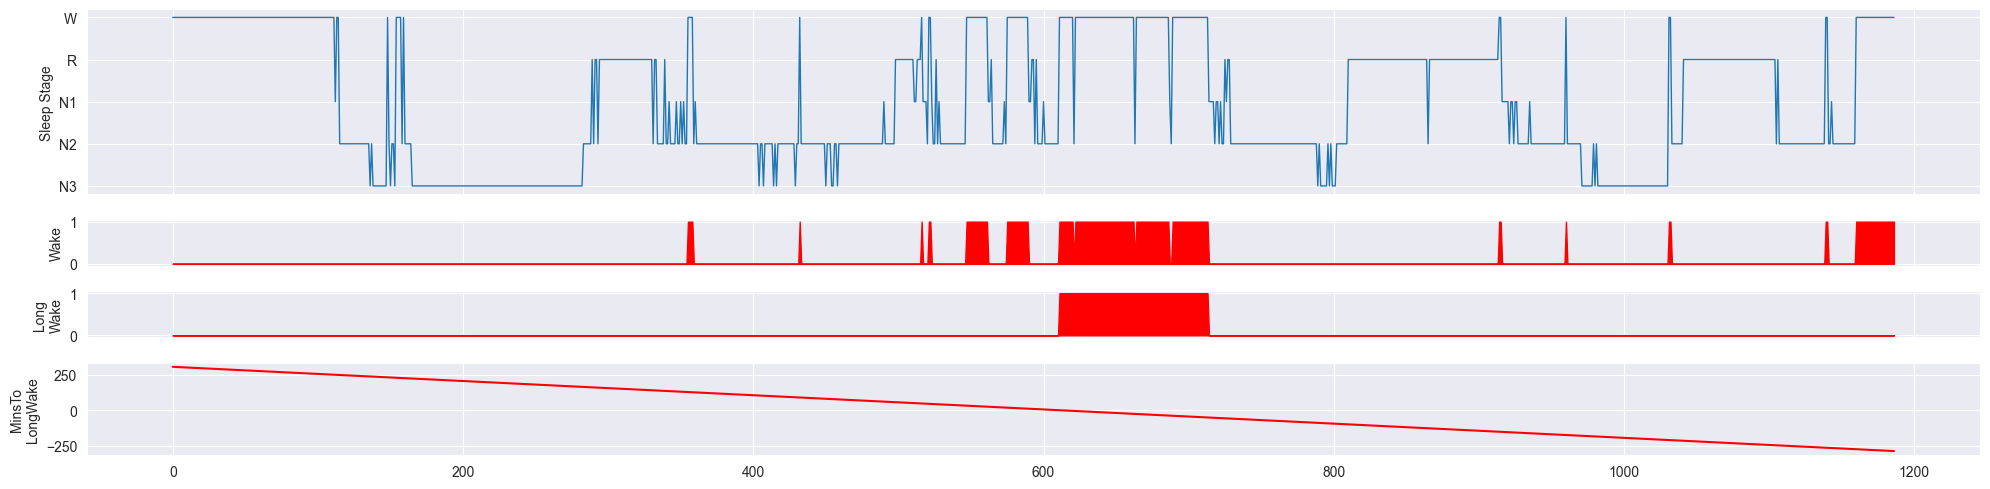

2024-11-01
2024-11-02
06:45:34


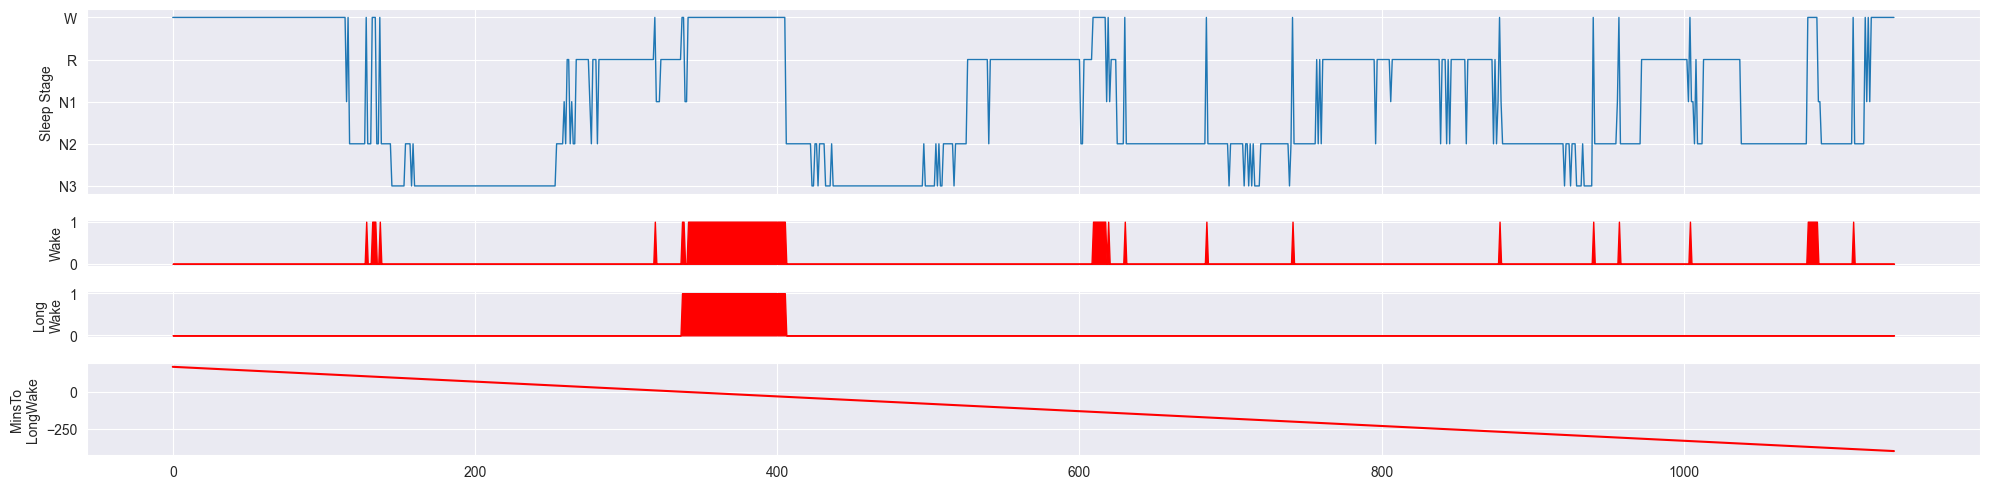

2024-11-05
02:37:00


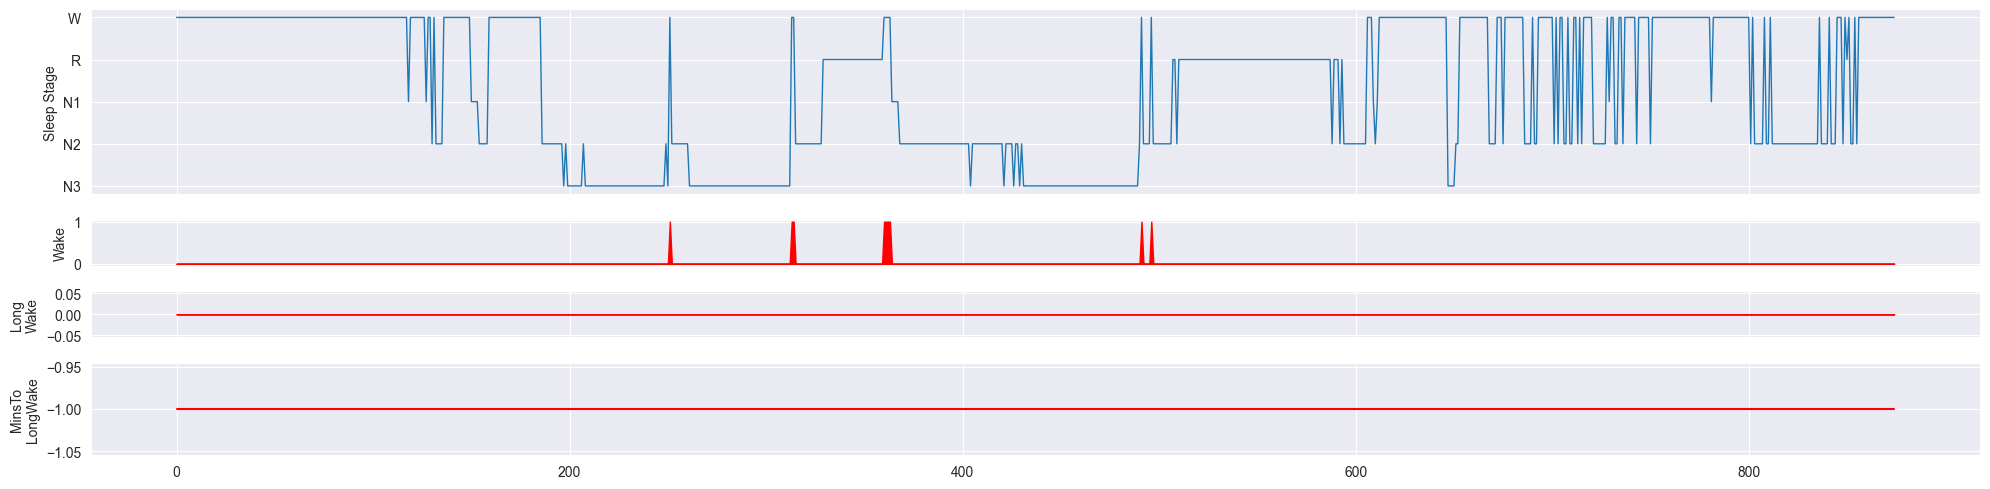

2024-11-21
2024-11-23
2024-11-25
2024-12-05
08:15:25


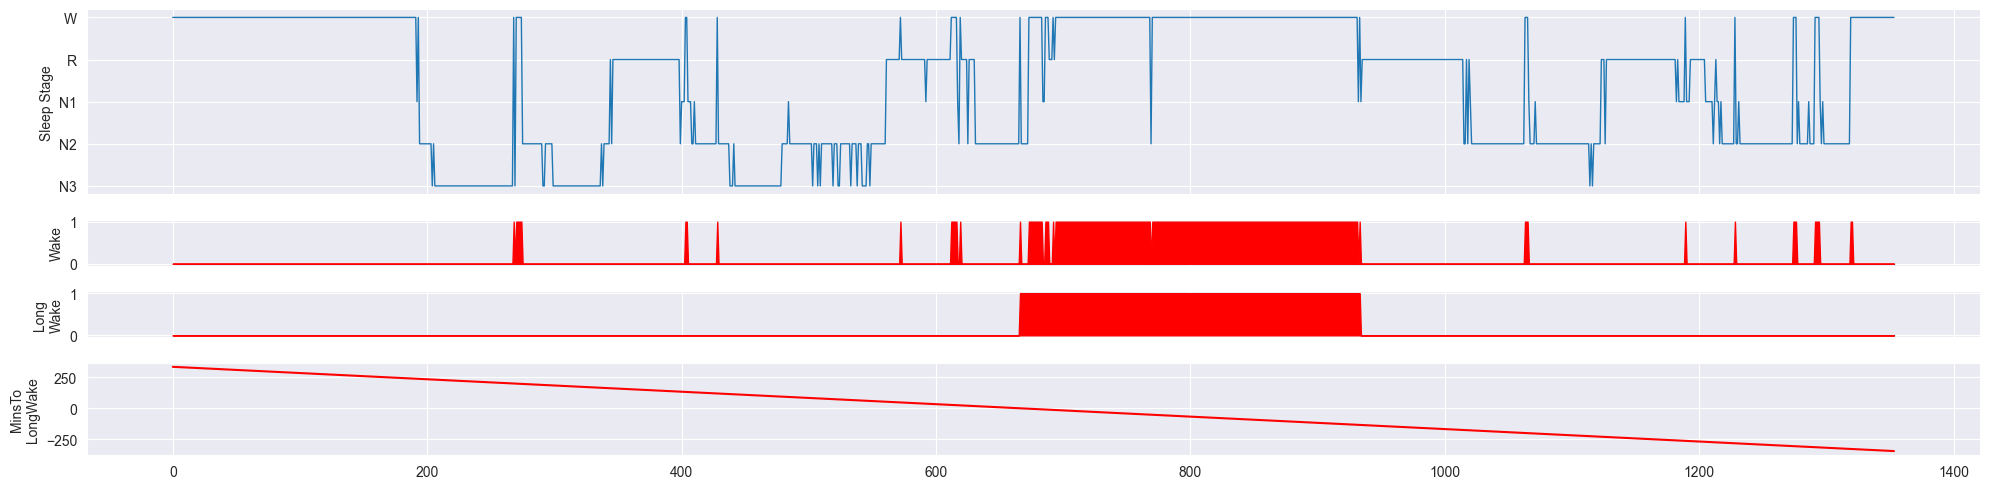

2024-12-12
2024-12-21
2024-12-28
08:08:53


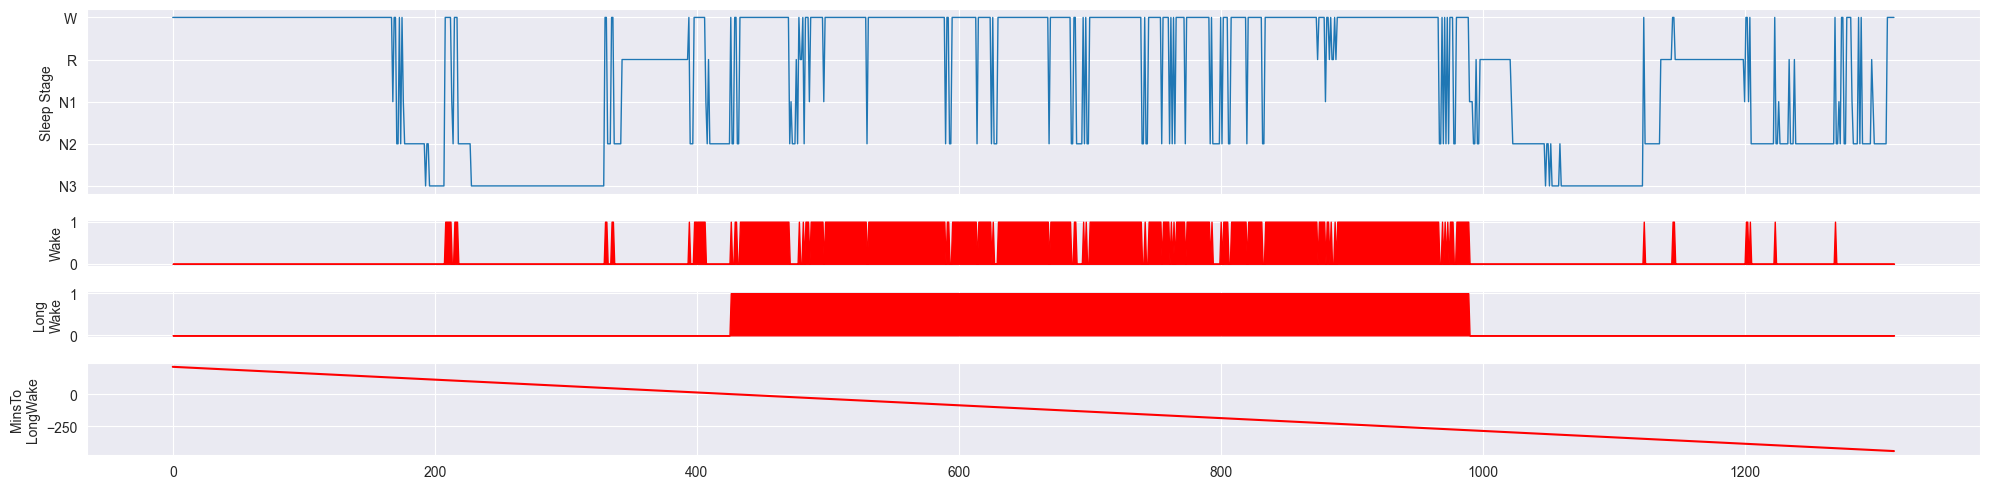

In [129]:
for index, row in possibly_insomnia_nights.iterrows():
    dayAndNightOf = row['dayAndNightOf']
    print(dayAndNightOf.date())
    #dt = pd.to_datetime(row['dayAndNightOf']).date()
    if str(dayAndNightOf.date()) in actual_insomnia_nights:
        print(row['wakeTime'].time())
        draw_day(dayAndNightOf)


